# Capstone Project: Sentiment Analysis on Airbnb Reviews and Price Prediction

### Contents:
- [Pre-processing](#Pre-processing)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)
- [Production Model](#Production-Model)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Pre-processing

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [37]:
listings = pd.read_csv('../data/listings_final.csv')

In [226]:
listings.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'availability_30',
       'number_of_reviews', 'instant_bookable',
       'calculated_host_listings_count', 'host_days_active',
       'air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'cooking_basics', 'elevator', 'gym', 'child_friendly', 'hot_tub',
       'pool', 'long_term_stays', 'pets_allowed', 'private_entrance', 'secure',
       'self_check_in', 'smoking_allowed', 'wheelchair_access',
       'description_text_length', 'transit_text_length',
       'distance_to_nearest_station', 'distance_to_city', 'sentiment_compound',
       'host_response_time_unknown', 'host_response_time_within_a_day',
       'host_response_rate_50-79%', 'host_response_rate_80-94%',
       'host_acceptance_rate_50-69%', 'host_acceptance_rate_70-89%',
       'host_acceptance_rate_unkn

In [3]:
listings.shape

(6973, 73)

### Transformation

The positively skewed listing price (target variable) and numerical features and  will be transformed to a log scale to approximate to normal distribution so as to conform to the normality assumption for linear regression models.

In [38]:
numerical_columns = ['accommodates', 'bedrooms', 'beds', 'price', 'security_deposit',
                     'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
                     'availability_30', 'number_of_reviews','calculated_host_listings_count', 'host_days_active',
                     'description_text_length','transit_text_length', 'distance_to_nearest_station',
                     'distance_to_city']

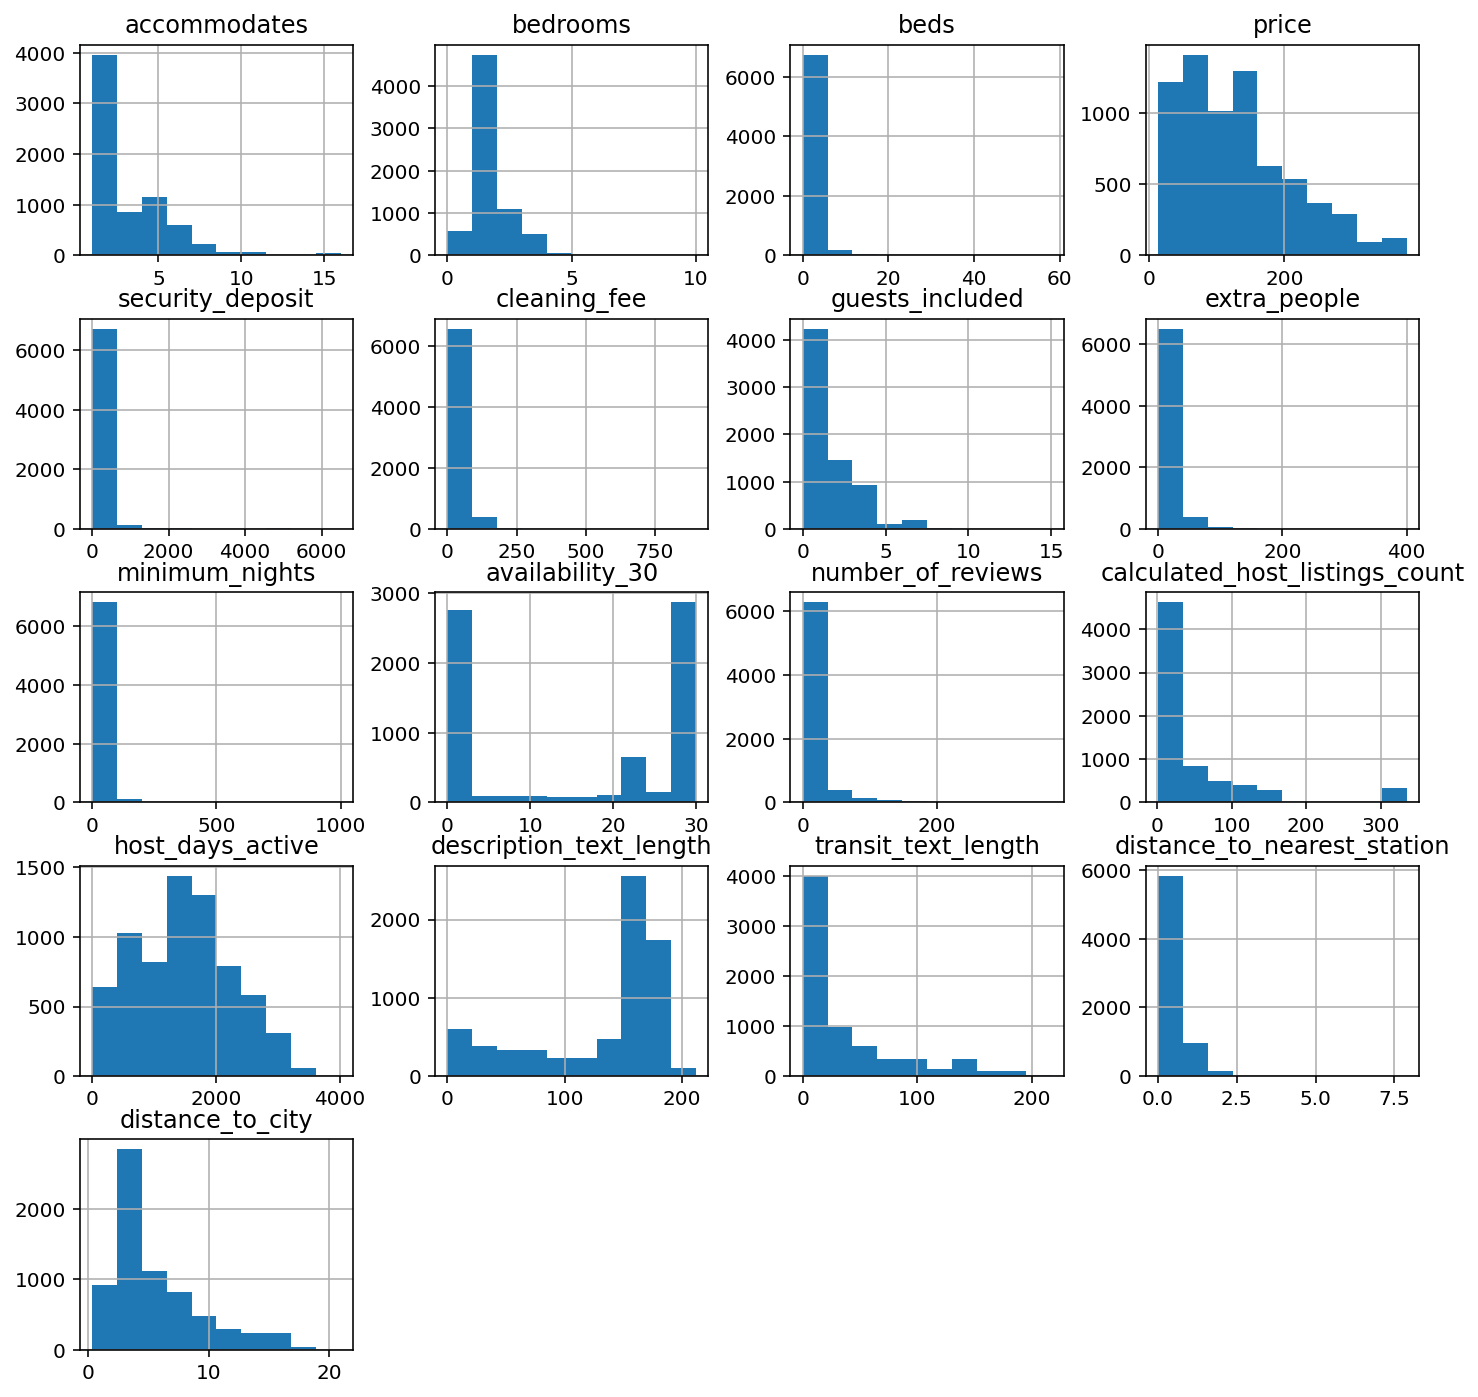

In [7]:
# Check original distribution of continuous numerical features 
listings[numerical_columns].hist(figsize=(12,12));

In [39]:
# Make a copy of listings dataframe before transforming variables
listings_copy = listings.copy()

# Log transforming right-skewed columns. Remove items not to be transformed
log_columns = [i for i in numerical_columns if i not in ['availability_30', 'host_days_active',
                                                               'description_text_length']]

for col in log_columns:
    listings_copy[col] = listings_copy[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01 as log(0) is undefined
    listings_copy[col] = np.log(listings_copy[col])

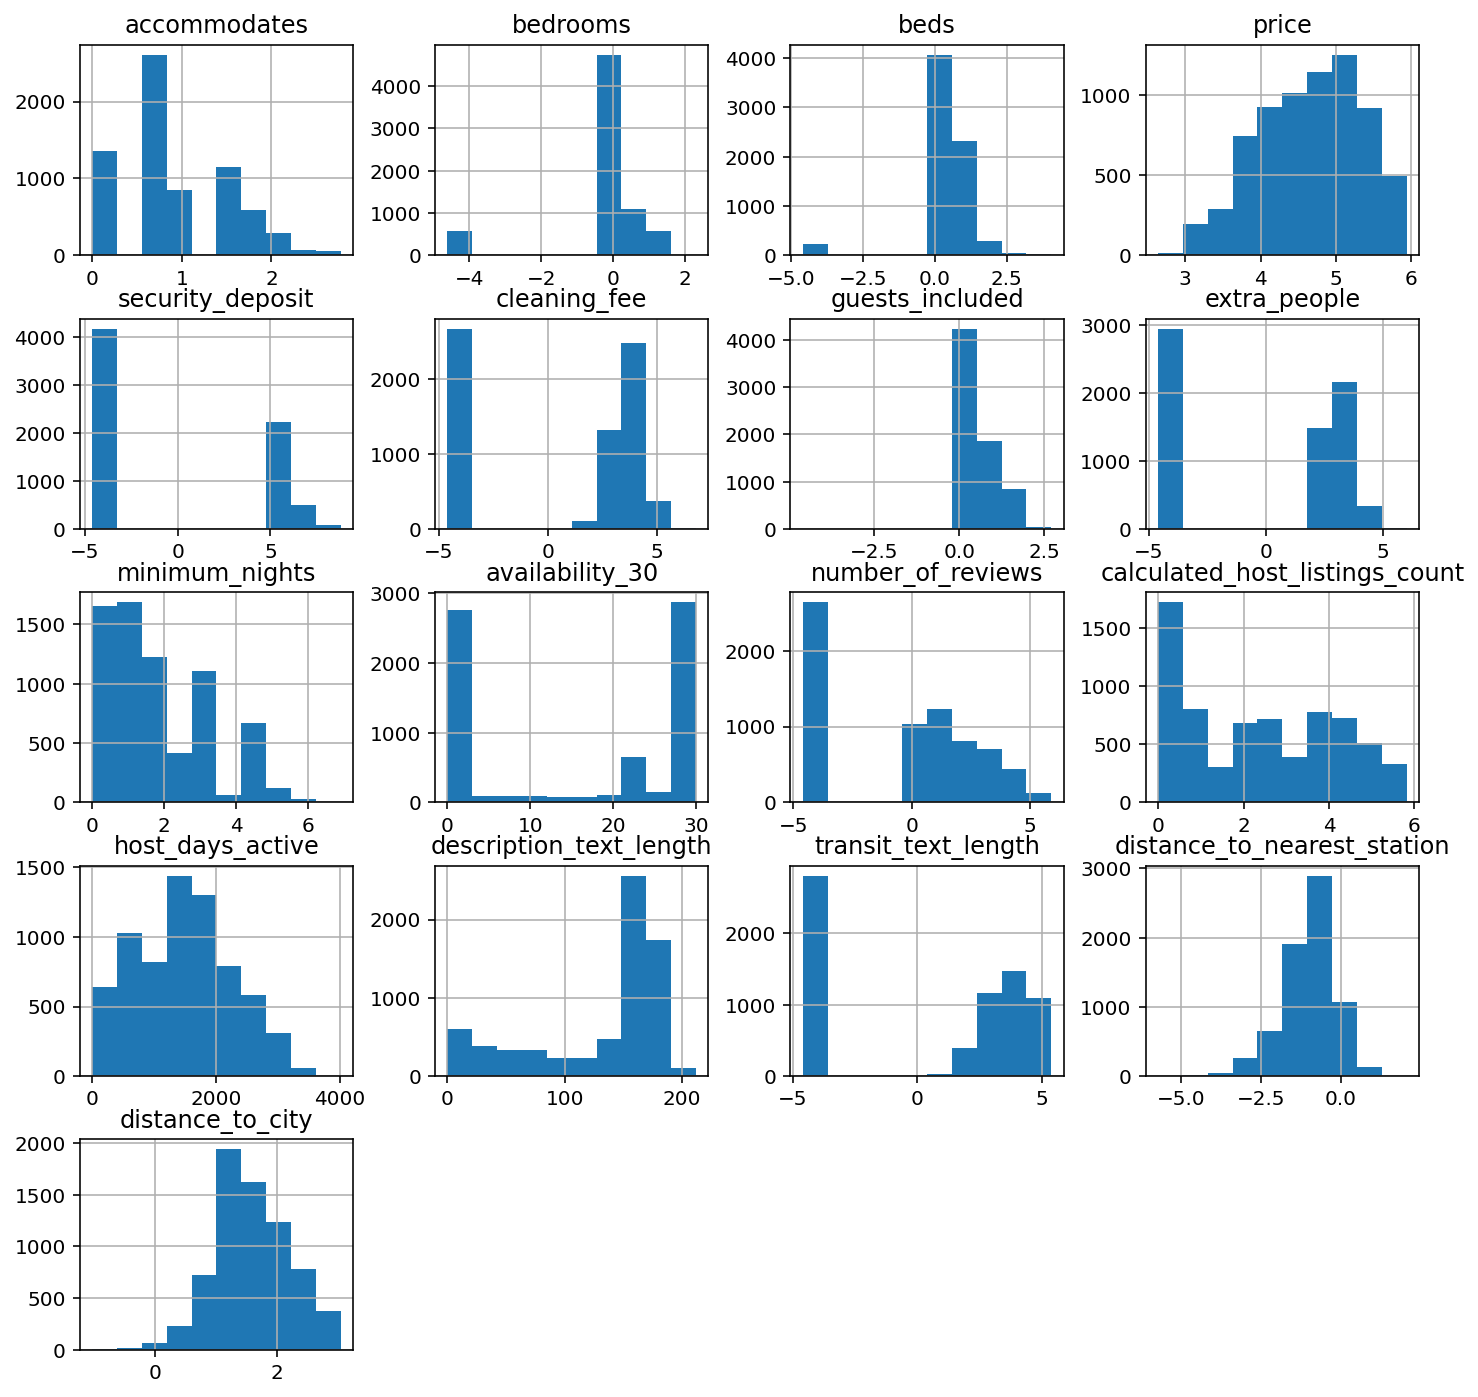

In [9]:
# Check distribution after log transformation
listings_copy[numerical_columns].hist(figsize=(12,12));

### Train-test split 

In [40]:
features = [x for x in listings_copy.columns if x not in ['price']]

X = listings_copy[features]
y = listings_copy.price

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardisation

The continuous numerical features will be standardised to the same scale so that they are comparable to avoid potential bias towards any features with higher magnitudes in the learning algorithms which use gradient descent (e.g. linear regression) and distance-based optimization techniques (e.g. k-nearest neighbours and support vector regression). 

In [62]:
numerical_columns = ['accommodates','bedrooms', 'beds', 'price', 'security_deposit',
                     'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
                     'availability_30', 'number_of_reviews','calculated_host_listings_count', 'host_days_active',
                     'description_text_length','transit_text_length', 'distance_to_nearest_station',
                     'distance_to_city']

In [63]:
# copy of cross_validation datasets
X_train_ss = X_train.copy()
X_test_ss = X_test.copy()

# To standardise all continuous numerical features
numerical_columns.remove('price')

# Apply standardization
for i in numerical_columns:
    
    # Instantiate StandardScalar
    ss = StandardScaler()
    
    # Fit and transform the training data
    X_train_ss[i] = ss.fit_transform(X_train_ss[[i]])
    
    # Transform the testing data
    X_test_ss[i] = ss.transform(X_test_ss[[i]])

In [14]:
X_train_ss.head()

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,number_of_reviews,instant_bookable,calculated_host_listings_count,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,cooking_basics,elevator,gym,child_friendly,hot_tub,pool,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,wheelchair_access,description_text_length,transit_text_length,distance_to_nearest_station,distance_to_city,sentiment_compound,host_response_time_unknown,host_response_time_within_a_day,host_response_rate_50-79%,host_response_rate_80-94%,host_acceptance_rate_50-69%,host_acceptance_rate_70-89%,host_acceptance_rate_unknown,neighbourhood_group_cleansed_central_region,neighbourhood_group_cleansed_east_region,neighbourhood_group_cleansed_north_region,neighbourhood_group_cleansed_north-east_region,neighbourhood_group_cleansed_west_region,room_type_entire_home/apt,room_type_private_room,room_type_shared_room,review_scores_rating_80-89/100,review_scores_rating_no_reviews,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_checkin_10/10,review_scores_communication_10/10,review_scores_location_9/10,review_scores_value_10/10,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,days_since_first_review_2-3_years,days_since_first_review_>4_years,days_since_last_review_>2_years,property_category_apartment,property_category_condo,property_category_hostel,property_category_svc_apt_hotel
6365,0,0,0.737911,0.127379,-0.232152,-0.814857,1.050665,-0.696039,-1.153713,1.054372,0.984007,-1.189130,0,1.225589,-0.667939,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.654812,0.526132,-0.560935,1.159714,0.000000,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4250,0,0,-1.444444,0.127379,-0.232152,-0.814857,0.576414,-0.696039,0.672249,0.723281,0.391641,-1.189130,1,0.954360,-1.005934,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.654812,1.153767,0.879179,-1.215726,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
691,0,1,2.014507,0.127379,1.829183,-0.814857,-1.251781,-0.696039,0.987844,-1.150109,-1.163320,0.814213,1,-0.020576,0.326393,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.810913,0.818568,-0.277376,-0.655175,0.808029,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0
533,0,0,-1.444444,0.127379,-0.232152,-0.814857,-1.251781,-0.696039,-1.153713,-1.150109,-1.163320,-1.189130,0,-1.250947,0.416787,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.565292,-1.195999,1.074041,0.531119,0.000000,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
6443,0,0,-0.353267,0.127379,-0.232152,-0.814857,0.942976,-0.696039,-1.153713,0.986083,0.984007,-1.189130,0,1.204425,-0.518593,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.446677,0.504997,0.846264,-1.380350,0.000000,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


## Modelling

### Approach

I will be evaluating 7 supervised machine learning algorithms in their performance in predicting the listing price of Airbnbs in Singapore, namely multiple linear regression (baseline), Lasso, ElasticNet, Support Vector, AdaBoost, Random Forests and XGBoost.

Lasso and ElasticNet are regularisation techniques to minimize model complexity and overfitting by reducing coefficients of less influential features by applying a penalty term. One advantage of Lasso is that it can reduce coefficients all the way to zero to eliminate non-important features from the model. 

Support Vector Regression is similar to linear regression but it has the flexibility to define how much error is acceptable in the model to provide a better fitting model.

Random Forest and XGBoost are more complex tree-based ensemble algorithms which make use of predictions from weak learners and combine them into a stronger learner, hence they are relatively robust against outliers and overfitting compared to simple decision trees.     

The performance of the models will be evaluated using the R-squared metric and Root Mean Square Error (RMSE). The R-squared metric measures the proportion of total variance in the listing price that is explained by the model and ranges from 0 to 1, with 0 indicating that the model does not improve prediction over the mean method, and 1 indicating perfect prediction. The RMSE is the square root of the variance of the residuals and indicates the absolute fit of the model to the data, with lower values indicating better model fit.

The different models are passed into a 5-fold cross-validation pipeline to do a gridsearch on the best hyperparameters to optimise the R-squared scores.

#### Linear Regression

In [13]:
# Instantiate model
lr = LinearRegression()

# Cross validation
lr_scores = cross_val_score(lr, X_train_ss, y_train, cv=5)

print('Results from: Linear Regression')
print(f'-----------------------------------')
print(f"Mean CV score: {lr_scores.mean()}")
print(f"CV score std: {lr_scores.std()}")

# Fit lr model
lr.fit(X_train_ss,y_train)

# Score lr model on training and test data
lr_score_train = lr.score(X_train_ss, y_train)
lr_score_test = lr.score(X_test_ss, y_test)
print(f'\nTraining R2: {lr_score_train}')
print(f'Testing R2: {lr_score_test}')

# Predict
lr_pred_train = lr.predict(X_train_ss)
lr_pred_test = lr.predict(X_test_ss)

print(f'\nTraining RMSE: {sqrt(mean_squared_error(np.exp(y_train), np.exp(lr_pred_train)))}')
print(f'Testing RMSE: {sqrt(mean_squared_error(np.exp(y_test), np.exp(lr_pred_test)))}')

# Print out coefficients.
lr_coef = pd.Series(lr.coef_, index=X_train_ss.columns).sort_values(ascending=False)
print("\nCoefficient:\n",lr_coef.head())

Results from: Linear Regression
-----------------------------------
Mean CV score: 0.6643885350075958
CV score std: 0.016614337818015516

Training R2: 0.6760509753648902
Testing R2: 0.6817823200500992

Training RMSE: 50.48599178187962
Testing RMSE: 51.87615638956549

Coefficient:
 neighbourhood_group_cleansed_east_region          1.083217e+10
neighbourhood_group_cleansed_north-east_region    1.083217e+10
neighbourhood_group_cleansed_west_region          1.083217e+10
neighbourhood_group_cleansed_north_region         1.083217e+10
neighbourhood_group_cleansed_central_region       1.083217e+10
dtype: float64


### Modelling pipeline

In [57]:
# Models to train
model_dict = {
    'enet': ElasticNet(),
    'lasso': Lasso(),
    'svr':SVR(),
    'rf':RandomForestRegressor(),
    'abr':AdaBoostRegressor(),
    'xgb': xgb.XGBRegressor(),
}

In [58]:
# For ease of viewing results later on
model_name = {
    'enet':'ElasticNet Regression',
    'lasso':'Lasso Regression',
    'svr':'Support Vector Regressor',
    'rf':'Random Forest Regressor',
    'abr':'AdaBoost Regressor',
    'xgb': 'XGBoost Regressor',
}

In [59]:
# pipelines, choosing hyperparameters and gridsearching
def pipeline(model):
    pipe = Pipeline([(model, model_dict[model])])
    return pipe

def params(model):
    if model == 'enet':
        return {'enet__alpha':np.arange(0, 1, 0.005),
               'enet__l1_ratio': np.arange(0.001, 1, 25),
               'enet__max_iter': [2000],
               'enet__random_state': [42]
               }
    
    elif model == 'lasso':
        return {
            'lasso__alpha':np.arange(0.005, 1, 0.005)
        }
    
    elif model == 'svr':
        return {
            'svr__C':[0.001,0.01,0.1,1],
            'svr__kernel':['linear','rbf']
        }
    
    elif model == 'rf':
        return {
            'rf__n_estimators':[500],
            'rf__max_depth':[6],
            'rf__min_samples_leaf':[1,2,5],
            'rf__min_samples_split':[10,30],
            'rf__random_state': [42]
        }
    
    elif model == 'abr':
        return {
            'abr__n_estimators':[50, 100,150,250],
            'abr__learning_rate':[0.1,0.3,0.6,1],
            'abr__random_state': [42]
        }
    
    elif model == 'xgb':
        return {
            'xgb__subsample' : [0.5,0.8], 
            'xgb__colsample_bytree' : [0.5,0.8], 
            'xgb__learning_rate' : [0.1,0.3],
            'xgb__max_depth' : [3],  
            'xgb__n_estimators' : [250],
            'xgb__reg_alpha' : [0, 0.05,0.1],
            'xgb__min_child_weight':[180],
            'xgb__reg_lambda' : [1],
            'xgb__gamma' : [0,0.1,0.3],
            'xgb__random_state': [42]
                             
        }
    
def grid_search(model,X_train = X_train_ss,y_train = y_train,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    pipe = pipeline(model)
    gs = GridSearchCV(pipe,param_grid = pipe_params,cv = 5,verbose=True, n_jobs=2)
    gs.fit(X_train,y_train)
    grid_search.train_score = gs.score(X_train,y_train)
    grid_search.test_score = gs.score(X_test,y_test)
    
    print(f'Results from: {model_name[model]}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'Mean R2 Score: {round(gs.best_score_,4)}')
    print(f'Train Score: {round(grid_search.train_score,4)}')
    print(f'Test Score: {round(grid_search.test_score,4)}')
    print(' ')

    print("Training RMSE:", round(sqrt(mean_squared_error(np.exp(y_train), np.exp(gs.best_estimator_.predict(X_train)))),4))  
    print("Testing RMSE:", round(sqrt(mean_squared_error(np.exp(y_test), np.exp(gs.best_estimator_.predict(X_test)))),4)) 

#### ElasticNet

In [155]:
grid_search('enet')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 132 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   16.5s finished


Results from: ElasticNet Regression
-----------------------------------
Best Hyperparameters: {'enet__alpha': 0.005, 'enet__l1_ratio': 0.001, 'enet__max_iter': 2000, 'enet__random_state': 42}
Mean R2 Score: 0.6646
Train Score: 0.6756
Test Score: 0.6808
 
Training RMSE: 50.3539
Testing RMSE: 51.7632


#### Lasso

In [168]:
grid_search('lasso')

Fitting 5 folds for each of 199 candidates, totalling 995 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 300 tasks      | elapsed:    2.9s


Results from: Lasso Regression
-----------------------------------
Best Hyperparameters: {'lasso__alpha': 0.005}
Mean R2 Score: 0.6563
Train Score: 0.6626
Test Score: 0.6643
 
Training RMSE: 50.9843
Testing RMSE: 52.3681


[Parallel(n_jobs=2)]: Done 995 out of 995 | elapsed:    8.5s finished


#### Support Vector 

In [17]:
grid_search('svr')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:   50.1s finished


Results from: Support Vector Regressor
-----------------------------------
Best Hyperparameters: {'svr__C': 1, 'svr__kernel': 'rbf'}
Mean R2 Score: 0.8009
Train Score: 0.908
Test Score: 0.8243
 
Training RMSE: 26.6895
Testing RMSE: 38.841


#### AdaBoost

In [245]:
grid_search('abr')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   43.2s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  1.0min finished


Results from: AdaBoost Regressor
-----------------------------------
Best Hyperparameters: {'abr__learning_rate': 0.1, 'abr__n_estimators': 150, 'abr__random_state': 42}
Mean R2 Score: 0.6247
Train Score: 0.6361
Test Score: 0.6154
 
Training RMSE: 52.3467
Testing RMSE: 55.3364


#### Random Forest

In [170]:
grid_search('rf')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  2.3min finished


Results from: Random Forest Regressor
-----------------------------------
Best Hyperparameters: {'rf__max_depth': 6, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 500, 'rf__random_state': 42}
Mean R2 Score: 0.7228
Train Score: 0.7535
Test Score: 0.7177
 
Training RMSE: 41.7645
Testing RMSE: 47.1385


#### XGBoost

In [172]:
grid_search('xgb')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:  2.6min finished


Results from: XGBoost Regressor
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.3, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__min_child_weight': 180, 'xgb__n_estimators': 250, 'xgb__random_state': 42, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}
Mean R2 Score: 0.7781
Train Score: 0.8435
Test Score: 0.8103
 
Training RMSE: 35.3553
Testing RMSE: 41.3804


## Model Evaluation

The results for the different machine learning regression models are summarised in the table below. The linear regression and regularisation models generally have a poorer prediction performance against the test data compared to the more complex support vector and tree-based regression models. The results also suggest that multi-collinearity or redundant features may not be a problem in the data given that Elastic and Lasso did not improve the linear regression model scores.

The Support Vector regression model performed the best among all models with the highest R^2 score of 0.824 and RMSE of \\$38.84 against the test data. However, this model has a high degree of overfitting with a variance of about 8% in the R^2 score and \\$12 in the RMSE between the train and test scores, hence may not generalize well to new unseen data.

**XGBoost** has the second best performance with a R^2 score of 0.81 and RMSE of \\$41.38 against the test data, and an acceptable variance of about 3% in the R^2 score and \\$5 in the RMSE between the train and test scores, hence it will provide better generalizibility and will be chosen for the production model.

|Models |$R^2$ (Train)  | $R^2$ (Test) | $R^2$ difference | RMSE (Train)   | RMSE (Test) | RMSE difference
|---	|---	  |---	       |---	            |---	    |---      |---
|Linear Regression 	|0.676 |0.682          	|0.006   	|50.49   	|51.88     |1.39
|ElasticNet   	|0.676 |0.681   	    |0.005   	|50.35   	|51.76     |1.41 
|Lasso          |0.663 |0.664   	    |0.001   	|50.98   	|52.37     |1.39
|Support Vector 	|0.908 |0.824          	|0.084   	|26.69   	|38.84     |12.15
|AdaBoost 	        |0.636 |0.615          	|0.021   	|52.35   	|55.34     |2.99
|Random Forest   	        |0.753 |0.718   	    |0.035   	|41.76   	|47.14     |5.38
|XGBoost |0.844 |0.810 	        |0.034   	|35.35   	|41.38     |6.03

### Performance of Selected Model 

In [64]:
# Re-instantiate XGBoost model with best hyperparameters

xgb_reg = xgb.XGBRegressor(max_depth=3, min_child_weight=180, n_estimators= 250, colsample_bytree=0.8,
                          learning_rate=0.3, reg_alpha=0, reg_lambda=1, subsample=0.8, gamma = 0.3,random_state=42)
# Fit model
xgb_reg.fit(X_train_ss, y_train)

# Predict
xgb_pred_train = xgb_reg.predict(X_train_ss)
xgb_pred_test = xgb_reg.predict(X_test_ss)

print("\nTraining r2:", round(r2_score(y_train, xgb_pred_train),4))
print("Testing r2:", round(r2_score(y_test, xgb_pred_test),4))

print(f'\nRMSE of training set: {sqrt(mean_squared_error(np.exp(y_train), np.exp(xgb_pred_train)))}')
print(f'RMSE of testing set: {sqrt(mean_squared_error(np.exp(y_test), np.exp(xgb_pred_test)))}')


Training r2: 0.8435
Testing r2: 0.8103

RMSE of training set: 35.35527709096853
RMSE of testing set: 41.380435759485145


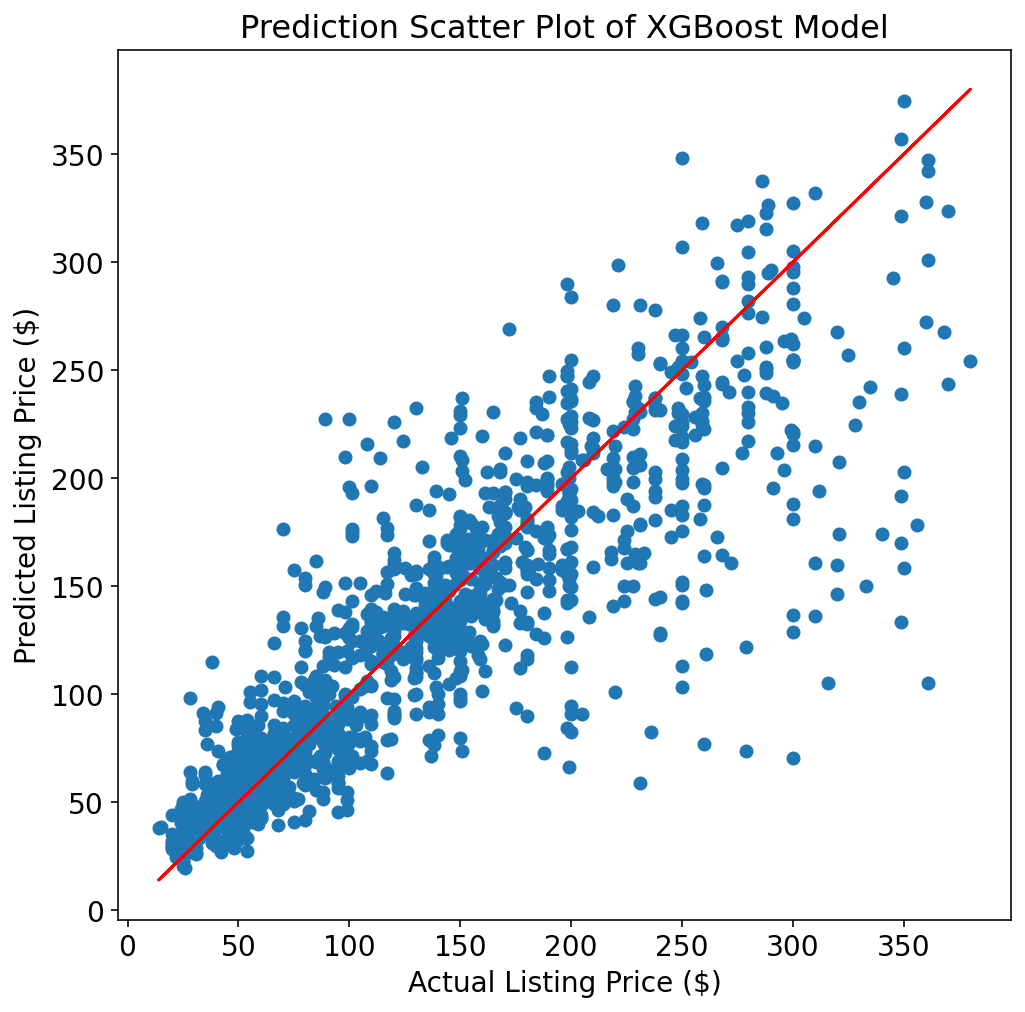

In [18]:
# Plot predicted values against actual values in test set
plt.figure(figsize=(8,8))

plt.scatter(x = np.exp(y_test), y = np.exp(xgb_pred_test));
plt.plot(np.exp(y_test), np.exp(y_test), color = 'r');

plt.xlabel('Actual Listing Price ($)', size =14)
plt.ylabel("Predicted Listing Price ($)", size = 14)
plt.title('Prediction Scatter Plot of XGBoost Model',fontsize=16)

plt.xticks(size=14)
plt.yticks(size=14);

In [26]:
# Create dataframe of actual versus predicted listing price. Sort by error values.

pred_df = pd.DataFrame({'actual_price': np.exp(y_test),
                        'pred_price':np.exp(xgb_pred_test)})
pred_df['error'] =  abs(pred_df['actual_price'] - pred_df['pred_price'])
pred_df['percent_error'] = (abs(pred_df['actual_price'] - pred_df['pred_price'])/pred_df['actual_price'])*100
pred_df.sort_values('error',ascending=False).head(10)

,actual_price,pred_price,error,percent_error
95,361.0,105.410294,255.589706,70.800473
351,300.0,70.337021,229.662979,76.554326
1672,349.0,133.673019,215.326981,61.698275
2083,316.0,105.426682,210.573318,66.637126
705,279.0,73.957253,205.042747,73.492024
2436,350.0,158.631073,191.368927,54.676836
6166,260.0,76.811211,183.188789,70.457227
2707,333.0,150.247269,182.752731,54.880700
3045,349.0,169.933624,179.066376,51.308417
3660,356.0,178.447723,177.552277,49.874235


In [20]:
# Filter listings dataframe based on predictions on test data
listings_filter = listings[listings.index.isin(pred_df.index)]

# Merge predictions to filtered listings dataframe
listings_pred = listings_filter.merge(pred_df, left_index=True, right_index=True)
listings_pred.sort_values('error',ascending=False).head(10)

,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,number_of_reviews,instant_bookable,calculated_host_listings_count,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,cooking_basics,elevator,gym,child_friendly,hot_tub,pool,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,wheelchair_access,description_text_length,transit_text_length,distance_to_nearest_station,distance_to_city,sentiment_compound,host_response_time_unknown,host_response_time_within_a_day,host_response_rate_50-79%,host_response_rate_80-94%,host_acceptance_rate_50-69%,host_acceptance_rate_70-89%,host_acceptance_rate_unknown,neighbourhood_group_cleansed_central_region,neighbourhood_group_cleansed_east_region,neighbourhood_group_cleansed_north_region,neighbourhood_group_cleansed_north-east_region,neighbourhood_group_cleansed_west_region,room_type_entire_home/apt,room_type_private_room,room_type_shared_room,review_scores_rating_80-89/100,review_scores_rating_no_reviews,review_scores_accuracy_9/10,review_scores_cleanliness_0-8/10,review_scores_checkin_10/10,review_scores_communication_10/10,review_scores_location_9/10,review_scores_value_10/10,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,days_since_first_review_2-3_years,days_since_first_review_>4_years,days_since_last_review_>2_years,property_category_apartment,property_category_condo,property_category_hostel,property_category_svc_apt_hotel,actual_price,pred_price,error
95,0,1,1,1.0,2.0,361.0,200.0,60.0,1,30.0,30,23,2,1,3,2417.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148,55,0.745283,4.108173,0.229850,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,0,361.0,105.410294,255.589706
351,0,1,1,1.0,1.0,300.0,0.0,0.0,1,0.0,1,30,0,0,1,1948.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0,0.603986,6.266646,0.000000,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,300.0,70.337021,229.662979
1672,0,0,1,1.0,1.0,349.0,0.0,50.0,1,0.0,7,29,0,1,1,1905.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,62,0,0.941791,7.078938,0.000000,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,349.0,133.673019,215.326981
2083,0,0,1,1.0,1.0,316.0,0.0,10.0,1,0.0,1,0,0,0,1,1096.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2,0,0.898826,9.108314,0.000000,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,316.0,105.426682,210.573318
705,0,0,2,1.0,2.0,279.0,0.0,0.0,1,0.0,1,0,0,0,1,1722.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0,1.417315,10.565413,0.000000,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,279.0,73.957253,205.042747
2436,0,0,3,2.0,2.0,350.0,500.0,50.0,1,0.0,90,0,27,0,1,2128.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,171,51,0.524561,2.077748,0.899939,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,350.0,158.631073,191.368927
6166,0,0,2,1.0,1.0,260.0,0.0,0.0,1,0.0,1,30,0,1,1,158.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,25,0,0.815239,16.101661,0.000000,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,260.0,76.811211,183.188789
2707,0,0,2,1.0,1.0,333.0,4500.0,0.0,1,120.0,25,23,0,0,6,1435.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,156,11,1.755083,5.608652,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,333.0,150.247269,182.752731
3045,0,0,2,2.0,1.0,349.0,0.0,0.0,1,0.0,1,0,3,1,1,2455.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,83,0,0.641511,3.159020,0.000000,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,349.0,169.933624,179.066376
3660,1,0,4,2.0,2.0,356.0,0.0,50.0,4,30.0,30,0,

In [28]:
# Descriptive statistics for the errors
pred_df.describe()

,actual_price,pred_price,error,percent_error
count,1395.000000,1395.000000,1395.000000,1395.000000
mean,131.683871,125.808929,26.265034,21.991390
std,81.165106,70.624313,31.987841,23.559377
min,14.000000,19.658459,0.019039,0.031934
25%,60.000000,65.130756,6.697021,7.049187
50%,119.000000,119.348892,16.061935,15.186883
75%,182.500000,171.431480,32.582428,29.010125
max,380.000000,374.400970,255.589706,250.276021


From the above scatter plot of actual versus predicted listing price based on the test data, we can see that the XGBoost prediction model performance looks strong with majority of the prediction scatter points falling very close to the actual listing price (shown by the diagonal red line which represents perfect prediction). The model is able to explain up to 81% of the variation in listing prices. On average, the predicted prices are within \\$26 (or about 22%) of actual prices.

There are however a few poor predictions where the model tends to underestimate the price of listings with higher prices.   A closer examination at the top 10 listings with biggest prediction errors, we can see that more than half of the listings correspond to the mid-price ranged apartment property type with entire home or private room, and they are located outside the city centre where prices are cheaper, with some more than 10km away. Hence, it is likely that the hosts had overestimated their listing price.  

### Feature Importance

In [29]:
# Create dataframe of feature importance from XGBoost model

feature_impt = xgb_reg.feature_importances_
features = X_test.columns
feature_impt_df = pd.DataFrame(columns=['feature', 'importance'], data=list(zip(features, feature_impt))).sort_values('importance',ascending=False)
feature_impt_df

,feature,importance
51,room_type_entire_home/apt,0.383112
71,property_category_svc_apt_hotel,0.169838
2,accommodates,0.049976
20,tv,0.041546
52,room_type_private_room,0.031113
57,review_scores_cleanliness_0-8/10,0.024872
3,bedrooms,0.024184
7,guests_included,0.018977
23,gym,0.018211
70,property_category_hostel,0.015087


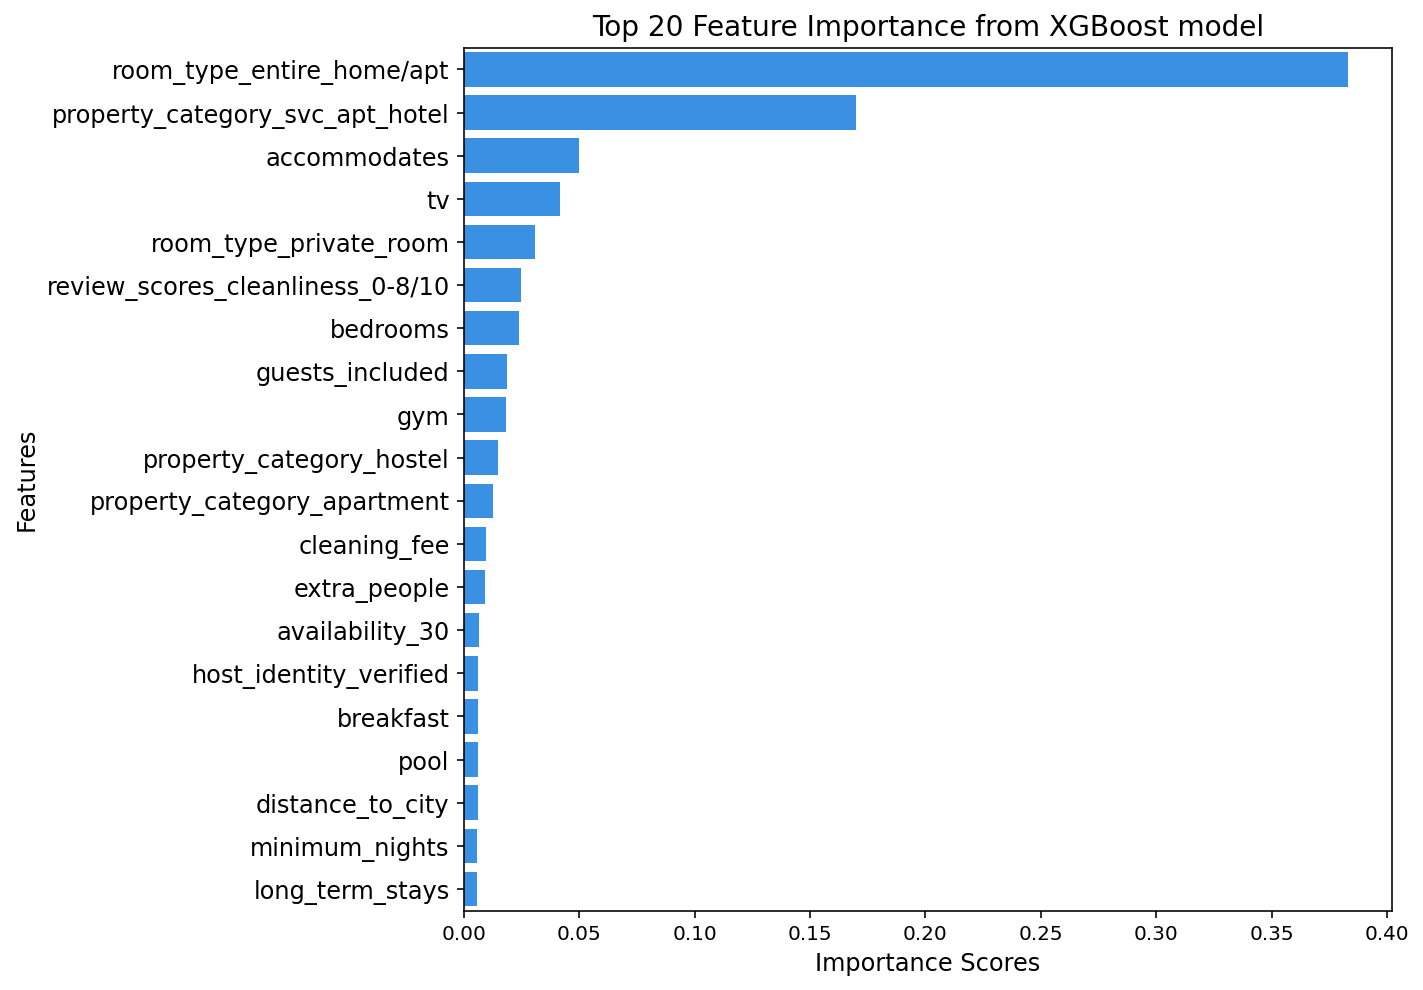

In [32]:
# Plot feature importance barchart

plt.figure(figsize = (10,7))
sns.barplot(data = feature_impt_df.head(20), x = 'importance', y = 'feature', color = 'dodgerblue')
plt.title('Top 20 Feature Importance from XGBoost model', fontsize=14)
plt.xlabel('Importance Scores',fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

In [31]:
xgb_reg.importance_type

'gain'

The feature importance scores from the XGBoost model indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The relative importance scores are based on the average training loss reduction gained when using a feature for splitting. 

From the barchart, we can observe that the features related to the characteristics of the property such as room type, property category, the number of people it can accommodate, and type of amenities, as well as review scores on cleanliness are ranked high in the list, with the `room_type_entire home/ apartment` feature dominating the other features in helping to predict the Airbnb's listing price.The top 10 features are:

- whether the room type is entire home/ apartment
- whether the property type is service apartment/ hotel
- the number of people the property can accommodate
- whether there is TV amenity
- whether the room type is private room
- whether the review scores for cleanliness range from 0-8/10
- the number of bedrooms
- the number of guests included in the listing price
- whether there is gym facility
- whether the property type is hostel

It is notable that the engineered `distance to city` feature came up among the top 20 features in the list, suggesting the importance of proximity to city centre in setting the listing price, whereas the other engineered `distance to nearest MRT station` feature was ranked among the lowest in the importance scores, likely due to the improved wider MRT network over the years which results in walkable distance to the MRT station from where most of the listings are located.     

## Production Model

The feature importance scores generated from the XGBoost model showed that majority of the features are of relatively low importance hence they only have very weak influence on the predicted listing price. It is also better to have a simpler model for production to reduce the amount of required user input. I will be using the top 30 features from above, and dropping a few of the review scores and host-related features such as `response time` and `accceptable rate` to make it more generalisable for potential new entrants looking to list their accommodation on Airbnb.  

### Feature Selection

In [66]:
# Filter features for production model
top_features = feature_impt_df.head(30)
top30_features = top_features.feature.tolist()

filter_list = ['review_scores_cleanliness_0-8/10','host_acceptance_rate_70-89%',
               'host_response_time_unknown','host_acceptance_rate_unknown']

production_features = [i for i in top30_features if i not in filter_list]
production_features

['room_type_entire_home/apt',
 'property_category_svc_apt_hotel',
 'accommodates',
 'tv',
 'room_type_private_room',
 'bedrooms',
 'guests_included',
 'gym',
 'property_category_hostel',
 'property_category_apartment',
 'cleaning_fee',
 'extra_people',
 'availability_30',
 'host_identity_verified',
 'breakfast',
 'pool',
 'distance_to_city',
 'minimum_nights',
 'long_term_stays',
 'hot_tub',
 'beds',
 'elevator',
 'calculated_host_listings_count',
 'number_of_reviews',
 'instant_bookable',
 'secure']

In [67]:
drop_features = [i for i in features if i not in production_features]

X_train_ss.drop(columns=drop_features, axis=1, inplace=True)
X_test_ss.drop(columns=drop_features, axis=1, inplace=True)

In [69]:
# Re-run XGBoost model to find best hyperparameters
grid_search('xgb')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   39.3s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:  1.3min finished


Results from: XGBoost Regressor
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__min_child_weight': 180, 'xgb__n_estimators': 250, 'xgb__random_state': 42, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 1, 'xgb__subsample': 0.8}
Mean R2 Score: 0.7775
Train Score: 0.8314
Test Score: 0.8007
 
Training RMSE: 36.2744
Testing RMSE: 41.8186


### Model Performance

A comparison of the production model performance (26 features) with the full model (72 features) is shown in the table below. There is negligible drop in prediction performance for the production model with reduced features. The production model is still able to explain 80.1% of the variations in  listing price, with a RMSE of \\$41.82 while improving generalizability. 

|Models |$R^2$ (Train)  | $R^2$ (Test) | $R^2$ difference | RMSE (Train)   | RMSE (Test) | RMSE difference
|---	|---	  |---	       |---	            |---	    |---      |---
|XGBoost (full features) 	|0.844 |0.810 	        |0.034   	|35.35   	|41.38     |6.03
|XGBoost (reduced features)   	|0.831 |0.801   	    |0.030   	|36.27   	|41.82     |5.55 

## Conclusion and Recommendations

Seven machine learning regression algorithms were evaluated in their predictive performance on Airbnb listing price in Singapore. The XGBoost regression model had the best predictive performance and was able to explain 81% of the variation in listing prices, with a RMSE of \\$41.38 on the test data, with negligible drop in model performance using a reduced set of 26 features for the production model.

The listing prices are generally higher for renting out serviced apartment/ hotel rooms or entire homes which can accommodate more guests. Likewise, accommodations with amenities such as TV, gym, pool and hot tub, and located close to the city at the central area also tend to fetch a higher listing price.   

Potential directions for future work to further improve the prediction model include the following:

- Use more accurate price data based on actual price paid by the guests. Such data is available for a fee in some websites such as AirDNA (https://www.airdna.co/).
- Incorporate the listing photos' image quality as a feature to the prediction model, using convolutional neural network techniques, as guests are more likely to book an accommodation with verified and attractive photos so hosts with verified photos may have the pricing power to list at higher prices.
- Include other proximity features such as accessibility to restaurants and supermarkets in the listing neighbourhood, as this is also an important factor in customers' consideration shown in the sentiment analysis of Airbnb reviews. 
- Add in more granular features specific to the accommodation unit such as the unit level and and whether there are good views from the unit, as units on higher floors with good views are likely to be listed at higher prices as seen in property transactions.